This notebook contains code for estimating the gender of the patient (either **M**: male, **F**: Female or **X**: unknown) from the content of their question, and who the question is about (Self = 1/0: about themselves or someone else).

## Load libaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from spacy.matcher import Matcher
from google.colab import drive

## Load data

In [ ]:
%%time

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to the .feather file
file_path = "/content/drive/MyDrive/diagnose_en_dataset.feather"

# Load the .feather file as a Pandas DataFrame
df = pd.read_feather(file_path)

# Print the DataFrame
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 530 ms, sys: 739 ms, total: 1.27 s
Wall time: 6.28 s


,id,Description,Doctor,Patient
0,0,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with dilige...,"Hi doctor,I am just wondering what is abutting..."
1,1,"Q. Every time I eat spicy food, I poop blood. ...",Hello. I have gone through your information an...,"Hi doctor, I am a 26 year old male. I am 5 fee..."
2,2,Q. Will Nano-Leo give permanent solution for e...,Hi. For further doubts consult a sexologist on...,"Hello doctor, I am 48 years old. I am experien..."
3,3,Q. Will Kalarchikai cure multiple ovarian cyst...,Hello. I just read your query. See Kalarachi K...,"Hello doctor, I have multiple small cysts in b..."
4,4,Q. I masturbate only by rubbing the tip of the...,Hi. For further doubts consult a sexologist on...,"Hi doctor, During masturbation I just rub the ..."


In [ ]:
# Load the pre-trained SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define the keywords for female and male patients
# NOTE: most of these keywords are generated using ChatGPT

# FEMALE
female_keywords = ["breast", "breastfeeding", "cervical", "cervix", "childbirth", "conception", "contraception", "cramps",
                   "cycle", "endometriosis", "female", "feminine", "fetus", "foetus", "girl", "gynecological", "gynecologist",
                   "gynecology", "hormonal", "hormone", "ivf", "lady", "mammogram", "maternal", "maternity", "menopause",
                   "menstrual", "menstruation", "milk", "obstetric", "obstetrics", "ovarian", "ovary", "ovulation", "pap",
                   "pelvic", "period", "postpartum", "pregnancy", "pregnant", "prenatal", "smear", "uterine", "uterus",
                   "vagina", "vaginal", "woman", "yeast"]

female_pron = ["her", "she"]

female_patterns = female_keywords + female_pron


# MALE
male_keywords = ["andropause", "baldness", "boy", "dysfunction", "ejaculation", "erect", "erectile", "erection", "foreskin",
                 "gentleman", "guy", "gynecomastia", "hormone", "impotence", "infertility", "libido", "male", "man", "masculine",
                 "penile", "penis", "premature", "prostate", "prostatectomy", "prostatitis", "scrotum", "sperm", "spermatozoa",
                 "testicle", "testicular", "testi", "testis", "testosterone", "varicocele", "vasectomy"]

male_pron = ["he", "him", "his"]

male_patterns = male_keywords + male_pron

## Function: check if input text contains specified keywords and determine gender
1. *check_gender*: for matching male / female keywords when the question is about 'self'
1. *check_gender_with_pron*: for matching male / female keywords plus the corresponding third person pronouns

**NOTE**: Since it's a *POC* we are making a simplistic assumption of binary gender classification. We acknowledge that an advanced version of the algorithm will have to consider more diverse gender classification. But we leave that as future work given that the project has certain time limit (= 8 weeks) to come up with a *POC*.

In [ ]:
def check_gender(text):
    doc = nlp(text)

    # Calculate the frequency of "female" health words
    female_freq = sum(1 for token in doc if token.text.lower() in female_keywords)

    # Calculate the frequency of "male" health words
    male_freq = sum(1 for token in doc if token.text.lower() in male_keywords)

    if (female_freq, male_freq) == (0, 0):
      return 'X'

    if female_freq >= male_freq:
        return 'F'
    else:
        return 'M'

In [ ]:
# Function to check if input text contains specified words and determine gender
def check_gender_with_pron(text):
    doc = nlp(text)

    # Calculate the frequency of "female" health words
    female_freq = sum(1 for token in doc if token.text.lower() in female_patterns)

    # Calculate the frequency of "male" health words
    male_freq = sum(1 for token in doc if token.text.lower() in male_patterns)

    # If no male / female keywords are found assign 'X' as the gender
    if (female_freq, male_freq) == (0, 0):
      return 'X'

    if female_freq >= male_freq:
        return 'F'
    else:
        return 'M'

## Determine if the question is about self or someone else

In [ ]:
# Predefined set of refering expressions
self_word_set = {'i'}
other_word_set = {'she', 'her', 'he', 'his', 'him'}

In [ ]:
# Function to check if input text is about the person asking the question or
# they are asking the question for someone else

def check_patient_reference(text):
    doc = nlp(text)

    # Calculate the frequency of words in the self_word_set
    self_freq = sum(1 for token in doc if token.text.lower() in self_word_set)

    # Calculate the frequency of words in the other_word_set
    other_freq = sum(1 for token in doc if token.text.lower() in other_word_set)

    # If the frequency of using words from 'other_word_set' is more than that of 'self_word_set'
    # then the question is most likely about someone else
    if other_freq > self_freq:
        return 0
    else:
        return 1

## Apply *`check_patient_reference`*, *`check_gender`* and *`check_gender_with_pron`* functions

In [ ]:
%%time

# Check reference
df['Self'] = df['Patient'].apply(check_patient_reference)

# Apply the functions conditionally to 'Patient' based on 'Self'
df['Gender'] = df.apply(lambda row: check_gender(row['Patient']) if row['Self'] == 1 else check_gender_with_pron(row['Patient']), axis=1)

CPU times: user 3h 20min 14s, sys: 26.1 s, total: 3h 20min 40s
Wall time: 3h 22min 34s


,id,Description,Doctor,Patient,Self,Gender
0,0,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with dilige...,"Hi doctor,I am just wondering what is abutting...",1,X
1,1,"Q. Every time I eat spicy food, I poop blood. ...",Hello. I have gone through your information an...,"Hi doctor, I am a 26 year old male. I am 5 fee...",1,M
2,2,Q. Will Nano-Leo give permanent solution for e...,Hi. For further doubts consult a sexologist on...,"Hello doctor, I am 48 years old. I am experien...",1,M
3,3,Q. Will Kalarchikai cure multiple ovarian cyst...,Hello. I just read your query. See Kalarachi K...,"Hello doctor, I have multiple small cysts in b...",1,F
4,4,Q. I masturbate only by rubbing the tip of the...,Hi. For further doubts consult a sexologist on...,"Hi doctor, During masturbation I just rub the ...",1,M


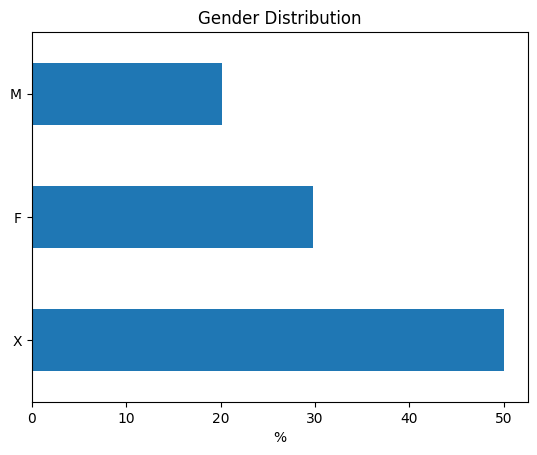

In [ ]:
# Calculate the percentages for the three gender options
gender_counts = df['Gender'].value_counts() * 100 / df['Gender'].value_counts().sum()

# Create a bar plot
gender_counts.plot(kind='barh')

# Set the labels and title
plt.ylabel('')
plt.xlabel('%')
plt.title('Gender Distribution')

# plt.tight_layout()
# Display the plot
plt.show()

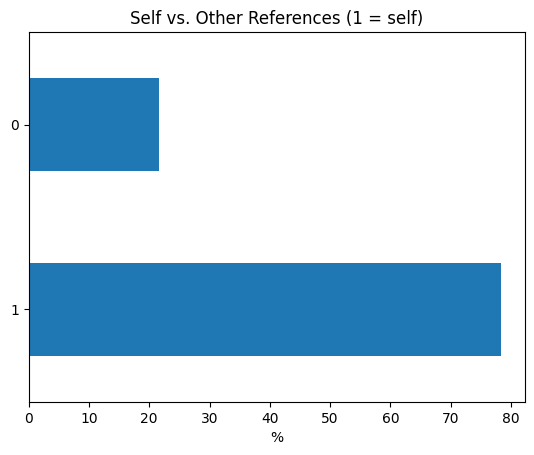

In [ ]:
# Calculate the percentages for self vs. other questions
gender_counts = df['Self'].value_counts() * 100 / df['Self'].value_counts().sum()

# Create a bar plot
gender_counts.plot(kind='barh')

# Set the labels and title
plt.ylabel('')
plt.xlabel('%')
plt.title('Self vs. Other References (1 = self)')

# Display the plot
plt.show()

### Save the data frame as a .feather file

In [ ]:
# # Specify the path to save the .feather file
output_path = "/content/drive/MyDrive/diagnose_en_dataset-patient_info-With_Gender_and_Reference.feather"

# # Save the DataFrame as a .feather file
df.to_feather(output_path)